In [14]:
# linear regression
# y = wx+b where w is weight, b is bias
# in ml they are parameters which machine finds to best fit our data

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


NB_DIR = Path.cwd()
PROJECT_ROOT = NB_DIR.parent

RAW_DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

xls_path = RAW_DATA_DIR / 'Concrete_Data.xls'
df = pd.read_excel(xls_path)



In [15]:
# prep data

df.rename(columns = {
  'Cement (component 1)(kg in a m^3 mixture)': 'cement',
  'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 'blast_furnace_slag',
  'Fly Ash (component 3)(kg in a m^3 mixture)': 'fly_ash',
  'Water  (component 4)(kg in a m^3 mixture)': 'water',
  'Superplasticizer (component 5)(kg in a m^3 mixture)': 'superplasticizer',
  'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 'coarse_aggregate',
  'Fine Aggregate (component 7)(kg in a m^3 mixture)': 'fine_aggregate',
  'Age (day)': 'age',
  'Concrete compressive strength(MPa, megapascals) ': 'compressive_strength'
}, inplace = True)

df = (df[df['age'] == 28]).copy()
df.drop(columns = ['age'], inplace = True)
df.sample(7)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,compressive_strength
917,148.0,175.0,0.0,171.0,2.00,1000.0,828.0,26.917143
548,289.0,0.0,0.0,192.0,0.00,913.2,895.3,25.573354
961,336.5,0.0,0.0,181.9,3.40,985.8,816.8,44.868340
400,250.0,180.0,95.0,159.0,9.45,860.0,800.0,67.865123
389,500.1,0.0,0.0,200.0,3.00,1124.4,613.2,44.133359
583,210.7,316.1,0.0,185.7,0.00,977.0,689.3,37.813622
971,312.7,144.7,0.0,127.3,8.00,999.7,822.2,44.523602


In [16]:
# define features and target

column_names = df.columns

target = 'compressive_strength'
features = column_names[column_names != target]

# y = wX + b
X = df[features] # feature vectors
y = df[target] # target

# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) # to get predictability in all instances of the model

print(f"Training Set: {len(y_train)}/{len(df)}")
print(f"Testing Set: {len(y_test)}/{len(df)}")

# use model = LiR

# Given the values of X and y, solve for w and b
model = LinearRegression().fit(X_train, y_train)

weights = model.coef_
intercept = model.intercept_

print(f'Weights: {weights}')
print(f'Intercept: {intercept}')

score = model.score(X_test, y_test)

print(f'Coefficient of Determination (R Squared) = {score:.3f}')

# R2 value will be if we use X_train and y_train? (train came out 0.782, what it means?)
# train score is mostly higher because The model "sees" the training data during its learning process, so it naturally fits that data better than "unseen" test data

# small gap in this suggests a balanced model, a high test R2 suggest 'overtraining'
# check other metrics like RMSE or k-fold-cross

Training Set: 340/425
Testing Set: 85/425
Weights: [ 0.17303948  0.15083341  0.10976379 -0.04728941  0.13121105  0.04160992
  0.05862292]
Intercept: -105.99063240392441
Coefficient of Determination (R Squared) = 0.736


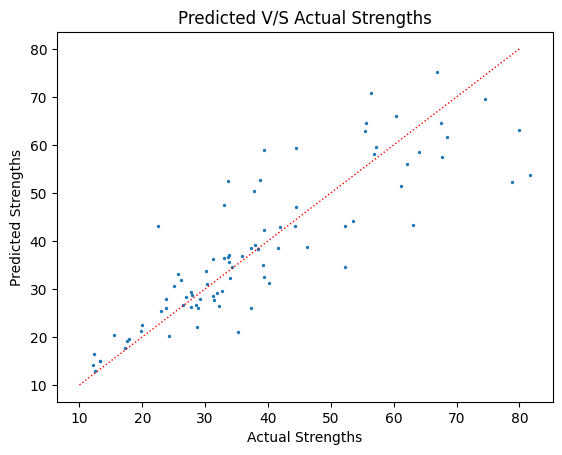

In [17]:
# use plots/graphs for further analysis

# scatter plot of predicted vs actual values
# X_test has multiple feature vectors
# predicted_strengths will have "compressive strengths" for ALL features in "X_test"
predicted_strengths = model.predict(X_test)

plt.scatter(
  x = y_test, # actual strenghts
  y = predicted_strengths, # predicted strengths
  s = 2,
  marker = 'o'
)

# line for y = x (best case) for all values
plt.plot(
  [10, 80],
  [10, 80],
  color = 'red',
  linestyle = 'dotted',
  linewidth = 1
)

plt.xlabel("Actual Strengths")
plt.ylabel("Predicted Strengths")

plt.title("Predicted V/S Actual Strengths")

plt.show()


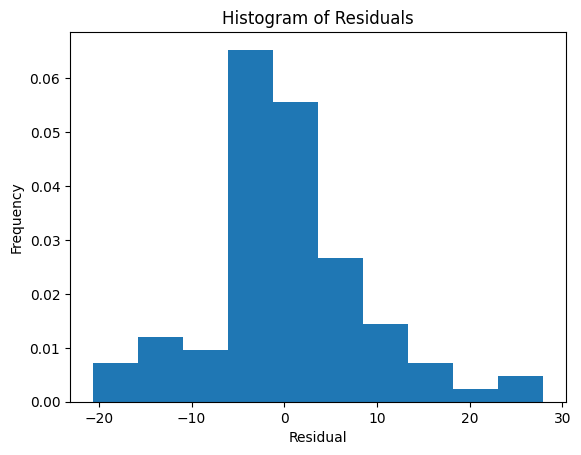

In [18]:
# residual = y_predicted - y_actual akaa in-sample residual/test-residual/out-of-sample error, prediction error/error term (in eco)
# how far were we off?

residuals = y_test - predicted_strengths
# postivie tests means overprediction/here overestimating strength (safety risk in concr)

# histogram of residuals
plt.hist(residuals, density = True)

plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.title('Histogram of Residuals')

plt.show()

In [38]:
cod = r2_score(y_test, predicted_strengths)
mae = mean_absolute_error(y_test, predicted_strengths)
mse = mean_squared_error(y_test, predicted_strengths)
rmse = np.sqrt(mse) # residual standard error


# lower rmse is always better
print(f'COD: {cod:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE:{rmse:.2f}')

# What "error margin" should you report for the predictions made?
# Example, the model predicts strength of 60MPa for a input feature vector.
# You should report it as "60 +- (MARGIN) MPa"

# +- we usually use assym band in production
# in histg we can see -20, +30 range that means we are going to overestimate str rather than underst

lower_percentile = np.percentile(residuals, 5)   # e.g., -20
upper_percentile = np.percentile(residuals, 95)  # e.g., +30

# Report: "60 MPa, but realistically
print(f"Range is {60+lower_percentile:.0f} to {60+upper_percentile:.0f}")
# i.e., [40, 90] MPa (asymmetric)
print(f"LR: {lower_percentile:.0f} & UR: {upper_percentile:.0f}")

COD: 0.74, MAE: 6.10, MSE: 75.36, RMSE:8.68
Range is 46 to 76
LR: -14 & UR: 16


In [ ]:
# SE_prediction = σ_residuals * √[1 + (1/n) + (X_test - X_mean)² / Σ(X_train - X_mean)²]; complex to calc
# if test sample is far from training data (extrapolation), SE increases → wider band
# If  test sample is near training centroid, SE decreases → tighter band


# if we simiply use margin = 1.96 * np.std(residuals) assume Gaussian we will NOT be ignoring residual variance (noise) but ignoring model coeef uncertainity (weights themselves are estimates)
# ignoring the leverage effect (how far test points are from training data

z_crit = 1.96 # for 95% CI
std_error = np.std(residuals, ddof=1) # ddof = 1 uses n-1 in the deno
margin_simple = z_crit * std_error
print(f"Range is {60 - margin_simple:.0f} to {60+upper_percentile:.0f}")
print(round(margin_simple, 0))

Range is 43 to 76
17.0
